# House Prices - Advanced Regression Techniques

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home, I am going to implement a ML regression model to predict each house price.

[you can know more about th data here](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)

In [1]:
# install requirements packages
#!pip install -r requirements.txt

In [2]:
# import libs 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# stats imports
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency, boxcox 

# sklearn imports
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
import xgboost as xgb

## Data Ingestion

In [3]:
# download house-prices-advanced-regression-techniques data using kaggle API
#!kaggle competitions download -c house-prices-advanced-regression-techniques --force

In [4]:
# unzip house-prices-advanced-regression-techniques.zip to get the data files
#!unzip house-prices-advanced-regression-techniques.zip

In [5]:
# activate venv house_pricing
#!.house_pricing\Scripts\activate.bat

In [6]:
# ls the data files 
!ls

data_description.txt
data_preprocessing.ipynb
data_preprocessing_0.ipynb
requirements.txt
test.csv
train.csv


In [7]:
!cat data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

## Import data 

In [8]:
# load data 
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	
MasVnrArea: Masonry veneer area in square feet

ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
ExterCond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
Foundation: Ty

## Preprocessing the data 

In [9]:
# copy the df
train1 = train.copy()
test1 = test.copy()

In [10]:
# explore the data
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [11]:
# fix datatypes
# ["OverallQual", "OverallCond"] represent ordinal categories
# convert them to object dtype for preprocessing
# train data
train1["OverallQual"] = train1["OverallQual"].astype("object")
train1["OverallCond"] = train1["OverallCond"].astype("object")

#test data
test1["OverallQual"] = test1["OverallQual"].astype("object")
test1["OverallCond"] = test1["OverallCond"].astype("object")

In [12]:
# create data frame for numeric features and df for categorical feature
y = train1[["SalePrice"]]
x_num = train1.select_dtypes(np.number)
x_cat = train1.select_dtypes("object")
test_num = test1.select_dtypes(np.number)
test_cat = test1.select_dtypes("object")

### Numerical Features EDA

In [13]:
# explore xnum df
x_num.head()

,Id,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,2003,2003,196.0,706,0,150,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,1976,1976,0.0,978,0,284,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,2001,2002,162.0,486,0,434,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,1915,1970,0.0,216,0,540,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,2000,2000,350.0,655,0,490,...,192,84,0,0,0,0,0,12,2008,250000


In [14]:
x_num.shape

(1460, 36)

In [15]:
test_num.shape

(1459, 35)

In [16]:
x_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   YearBuilt      1460 non-null   int64  
 5   YearRemodAdd   1460 non-null   int64  
 6   MasVnrArea     1452 non-null   float64
 7   BsmtFinSF1     1460 non-null   int64  
 8   BsmtFinSF2     1460 non-null   int64  
 9   BsmtUnfSF      1460 non-null   int64  
 10  TotalBsmtSF    1460 non-null   int64  
 11  1stFlrSF       1460 non-null   int64  
 12  2ndFlrSF       1460 non-null   int64  
 13  LowQualFinSF   1460 non-null   int64  
 14  GrLivArea      1460 non-null   int64  
 15  BsmtFullBath   1460 non-null   int64  
 16  BsmtHalfBath   1460 non-null   int64  
 17  FullBath       1460 non-null   int64  
 18  HalfBath

C:\Users\moham\anaconda3\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


<Figure size 1440x1008 with 0 Axes>

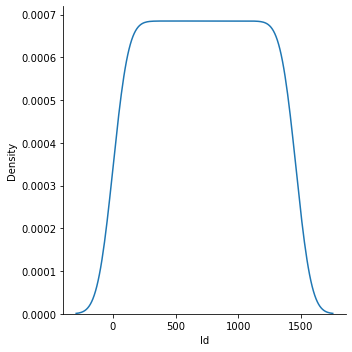

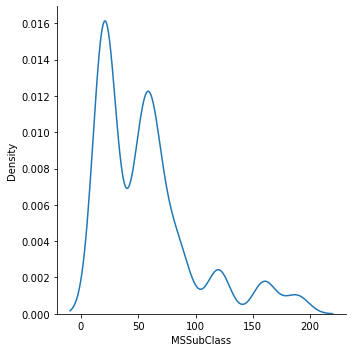

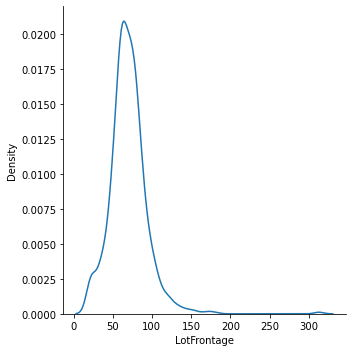

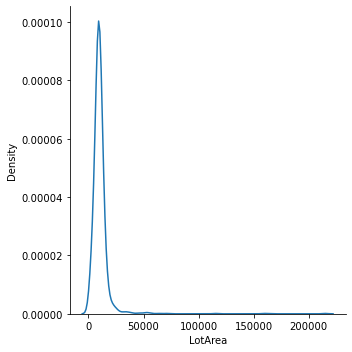

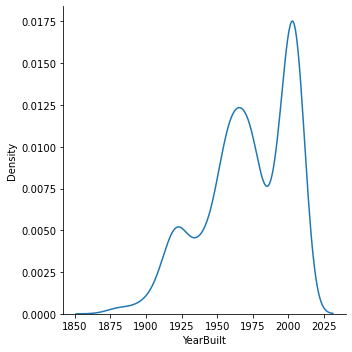

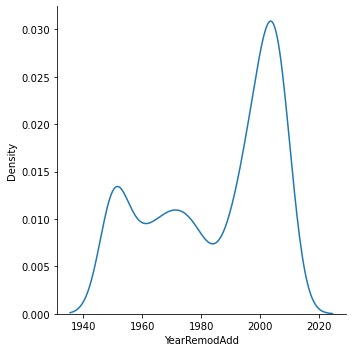

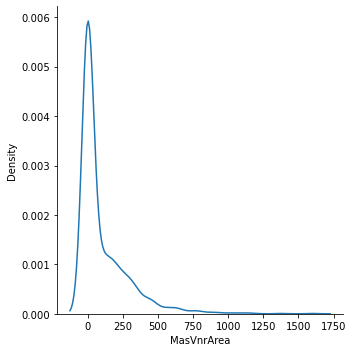

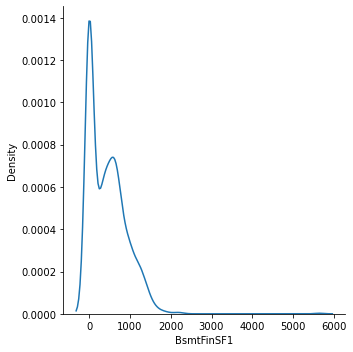

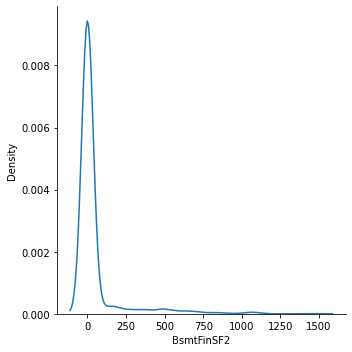

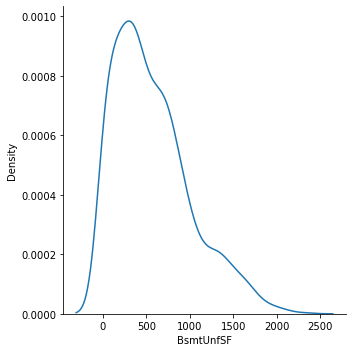

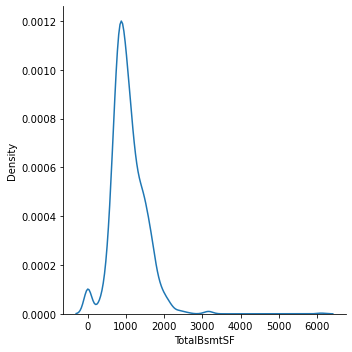

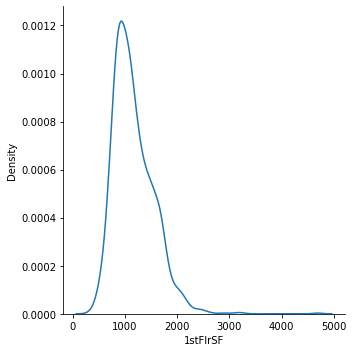

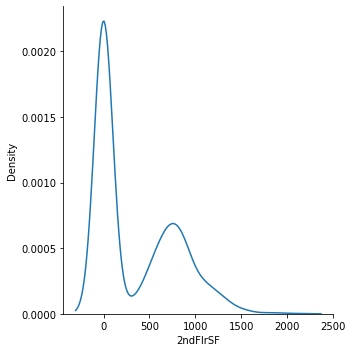

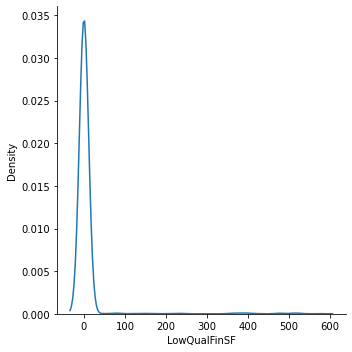

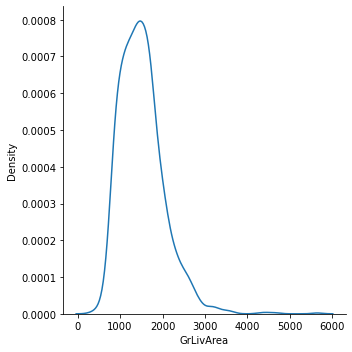

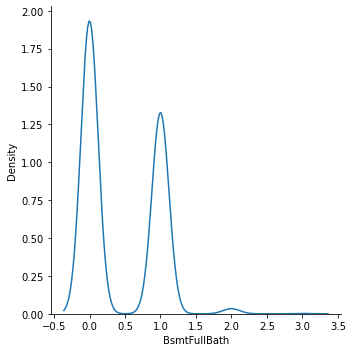

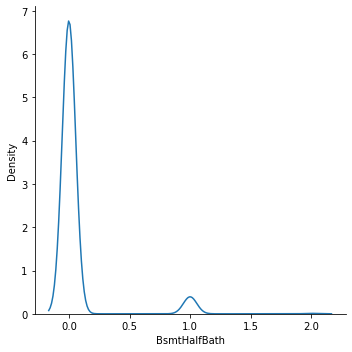

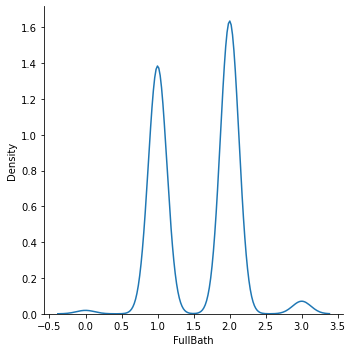

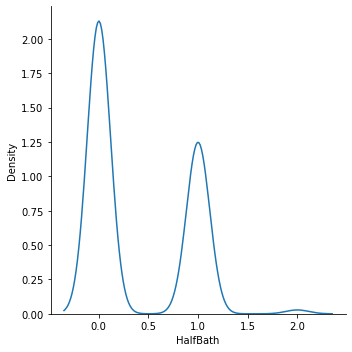

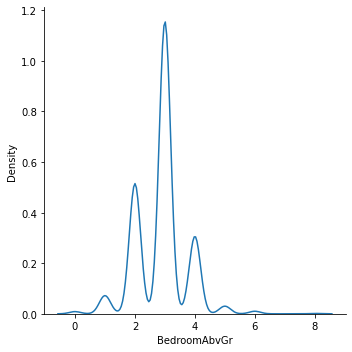

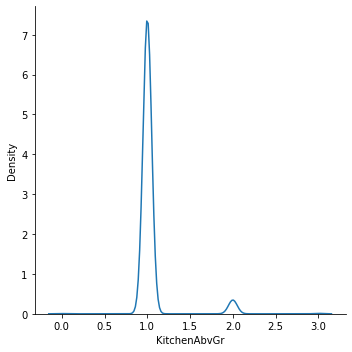

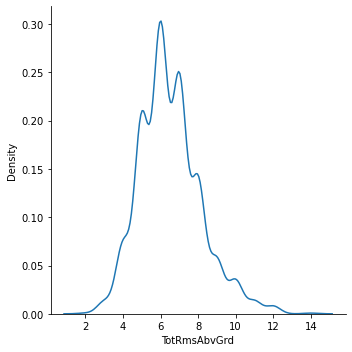

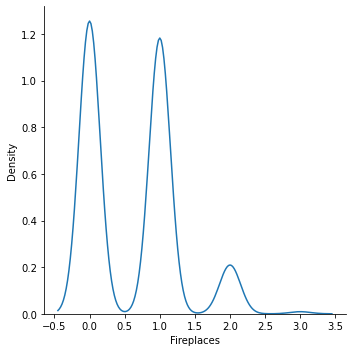

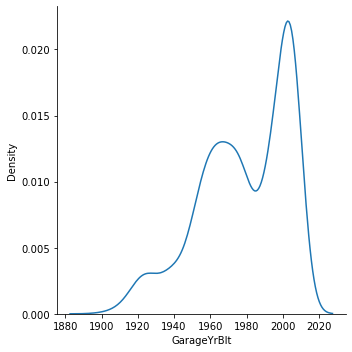

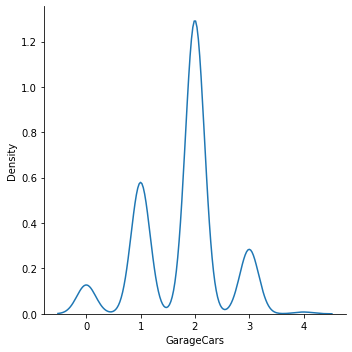

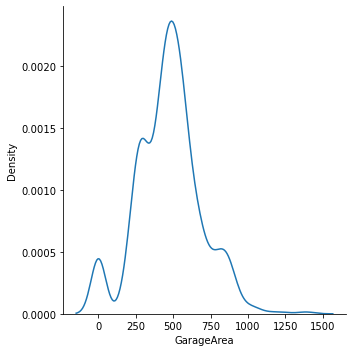

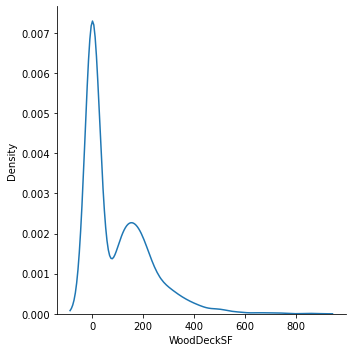

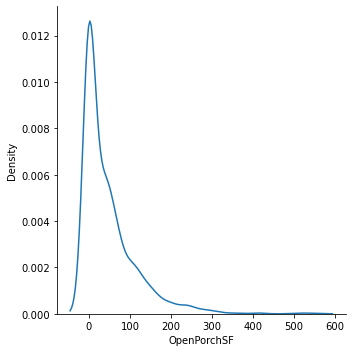

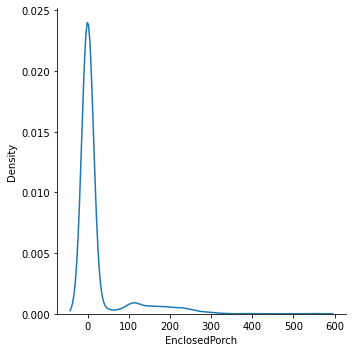

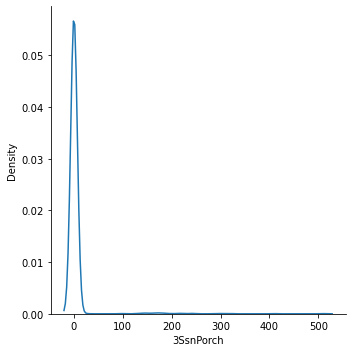

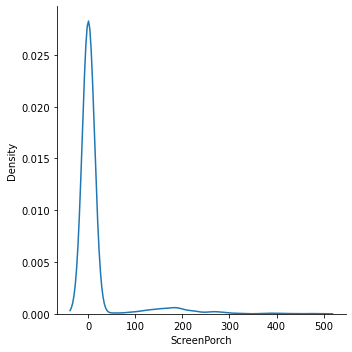

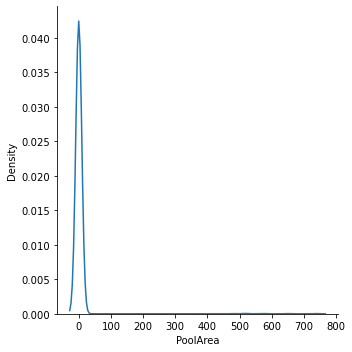

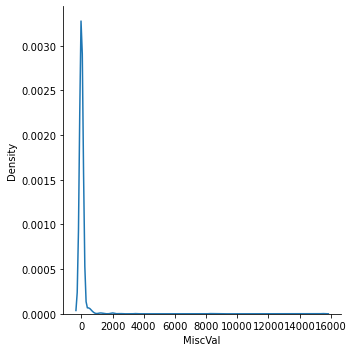

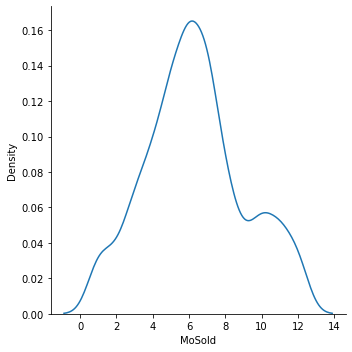

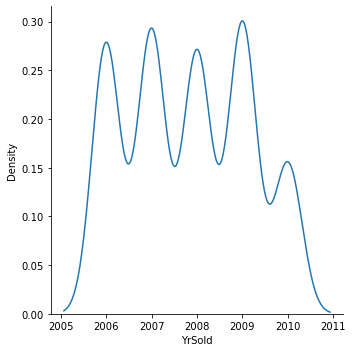

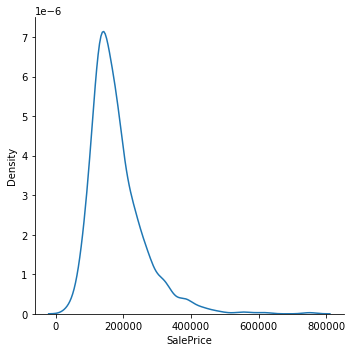

In [17]:
# numeric features distribution
# build the figure
fig = plt.figure(figsize=(20, 14))
for col in x_num.columns:
    sns.displot(x_num[col], kind = "kde")

#### Null Values imputation

In [18]:
# null counts
x_num.isnull().sum()

Id                 0
MSSubClass         0
LotFrontage      259
LotArea            0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

In [19]:
"""
Low null values counts, Fill nulls with the medien
"""
x_num.fillna(x_num.median(), inplace = True)

C:\Users\moham\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [20]:
# apply to the test data
"""
Low null values counts, Fill nulls with the medien
"""
test_num.fillna(x_num.median(), inplace = True)

In [21]:
# test for null counts for train and test
x_num.isnull().sum()

Id               0
MSSubClass       0
LotFrontage      0
LotArea          0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SalePrice        0
dtype: int64

In [22]:
test_num.isnull().sum()

Id               0
MSSubClass       0
LotFrontage      0
LotArea          0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64

In [23]:
# apply to the test data
"""
drop from train and test
"Id" --> identification column
"MSSubClass" --> not numeric represent dwelling included in the sell
"""
x_num.drop(["Id", "MSSubClass"], axis =  1, inplace = True)
test_num.drop(["Id", "MSSubClass"], axis =  1, inplace = True)

C:\Users\moham\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Transform Data Using log transformation Transformation

In [24]:
# apply boxcox transformation
x_num = x_num.apply(np.log1p)

In [25]:
test_num = test_num.apply(np.log1p)

#### Explore Correlation and Check Collinearity

<AxesSubplot:>

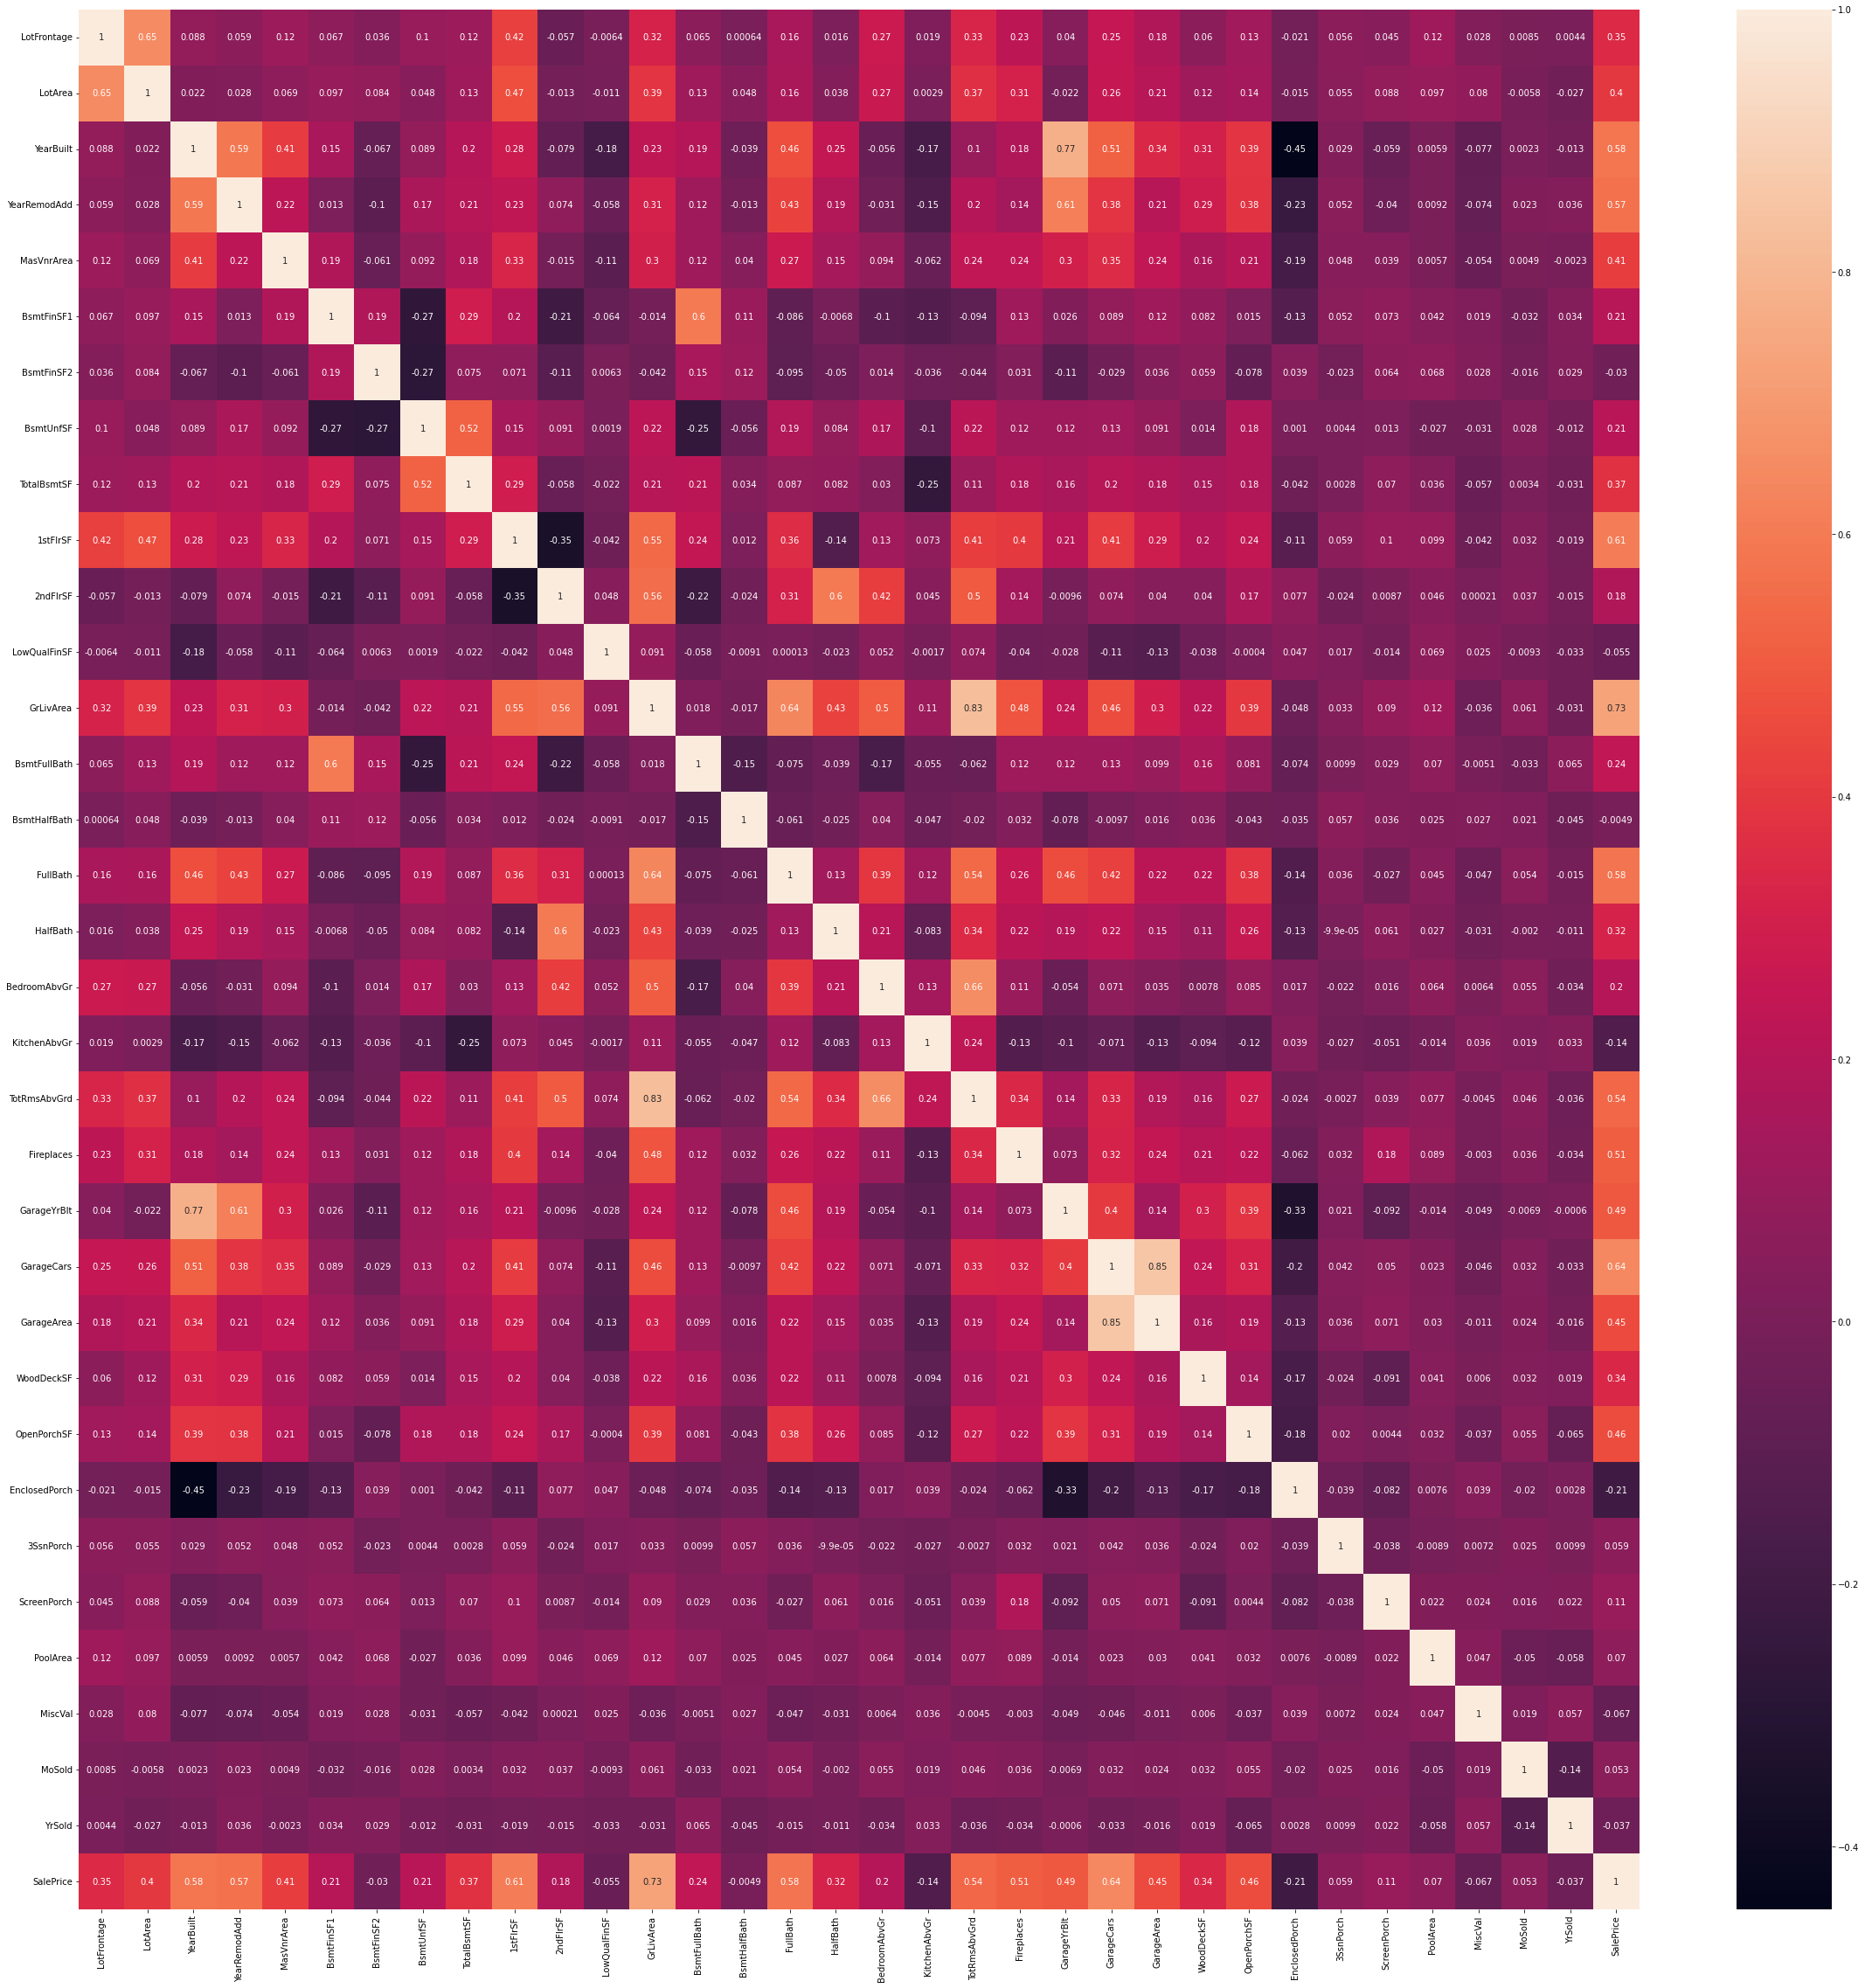

In [26]:
# plot corr heat map
corr_map = x_num.corr()

plt.figure(figsize = (40, 40))
sns.heatmap(corr_map, annot = True)

In [27]:
# print the corr between predictor and target variable in descending order
target_corr = corr_map["SalePrice"].sort_values(ascending = False)
target_corr

SalePrice        1.000000
GrLivArea        0.730254
GarageCars       0.641561
1stFlrSF         0.608955
YearBuilt        0.584443
FullBath         0.580297
YearRemodAdd     0.565590
TotRmsAbvGrd     0.539998
Fireplaces       0.508925
GarageYrBlt      0.493987
OpenPorchSF      0.459948
GarageArea       0.454898
MasVnrArea       0.413318
LotArea          0.399923
TotalBsmtSF      0.372838
LotFrontage      0.346237
WoodDeckSF       0.343039
HalfBath         0.320925
BsmtFullBath     0.238945
BsmtUnfSF        0.208233
BsmtFinSF1       0.208099
BedroomAbvGr     0.197664
2ndFlrSF         0.180778
ScreenPorch      0.105857
PoolArea         0.069949
3SsnPorch        0.058827
MoSold           0.053096
BsmtHalfBath    -0.004890
BsmtFinSF2      -0.030361
YrSold          -0.037261
LowQualFinSF    -0.054513
MiscVal         -0.067054
KitchenAbvGr    -0.144278
EnclosedPorch   -0.207263
Name: SalePrice, dtype: float64

#### Check Multicollinearity using Varience Inflation Factor


In [28]:
# Check Multi Collinearity
# VIF dataframe
# vif features df without target variable
vif_features = x_num.drop(["SalePrice"], axis = 1)

# get vif values for each feature
vif_values = pd.DataFrame()
vif_values["feature"] = vif_features.columns
  
# calculating VIF for each feature
vif_values["vif"] = [variance_inflation_factor(vif_features.values, i)
                          for i in range(len(vif_features.columns))]
  
vif_values

,feature,vif
0,LotFrontage,3.450495e+02
1,LotArea,6.627616e+02
2,YearBuilt,1.114031e+06
3,YearRemodAdd,1.041497e+06
4,MasVnrArea,2.313801e+00
5,BsmtFinSF1,6.347045e+00
6,BsmtFinSF2,1.395535e+00
7,BsmtUnfSF,2.377420e+01
8,TotalBsmtSF,8.060162e+01
9,1stFlrSF,8.321657e+03


## Build a model as an Evalution to our Preprocessing 

In [29]:
# initalize the model
#lr = LinearRegression()

In [30]:
# fit the model to the data
#lr.fit(train_1, y)

In [31]:
# predict the target for the cv data set
#lr_predictions = lr.predict(train_1)

In [32]:
# compute the RMSE, and MSE
#MAE = mean_absolute_error(lr_predictions, y)
#MSE = mean_squared_error(lr_predictions, y)
#RMSE = np.sqrt(MSE)

In [33]:
# print the RMSE, and MSE
#print(f"Mean Absolute Error: {MAE}")
#print(f"Mean Squared Error: {MSE}")
#print(f"Root Mean Squared Error: {RMSE}")

In [34]:
# get model coeff
#lr.coef_

In [35]:
# get the intercept value
#lr.intercept_

In [36]:
# get the r2 
#r2_score(y, lr_predictions)

In [37]:
# get the residuals 
#residuals = lr_predictions - y

In [38]:
# plot residuals plot
#plt.figure(figsize=(14, 8))
#sns.residplot(lr_predictions, residuals)

In [39]:
# draw the distribution of residuals
#sns.displot(residuals, kind = "kde")